Generating synthetic data...
Data generation complete.
Performing Exploratory Data Analysis...


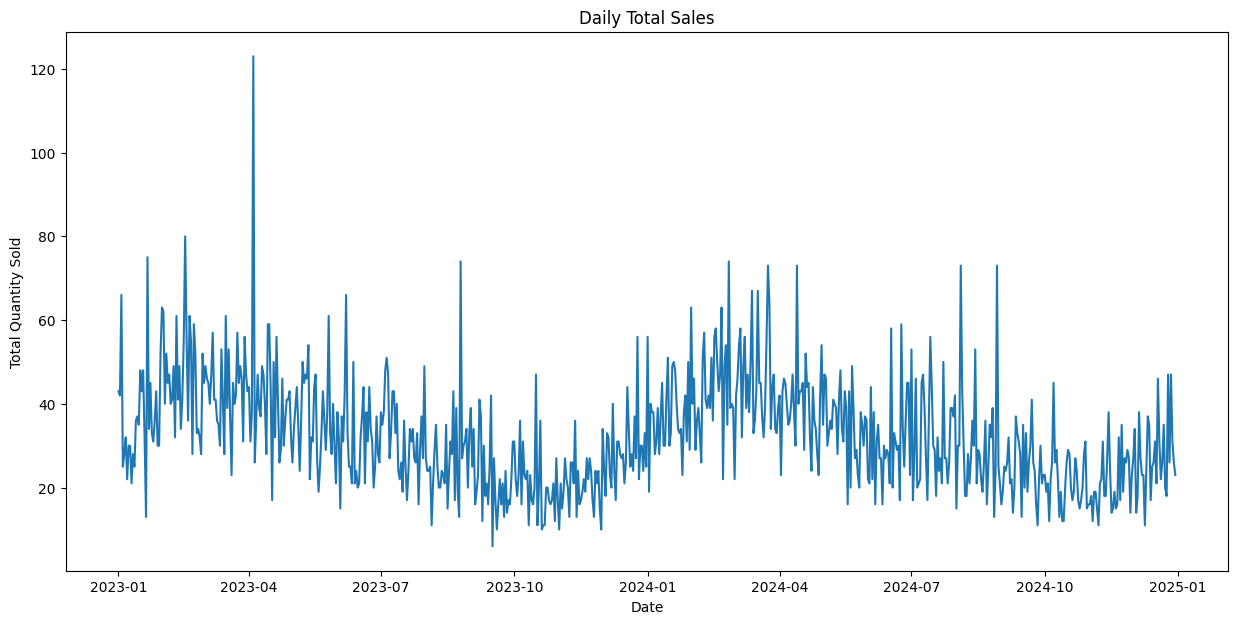

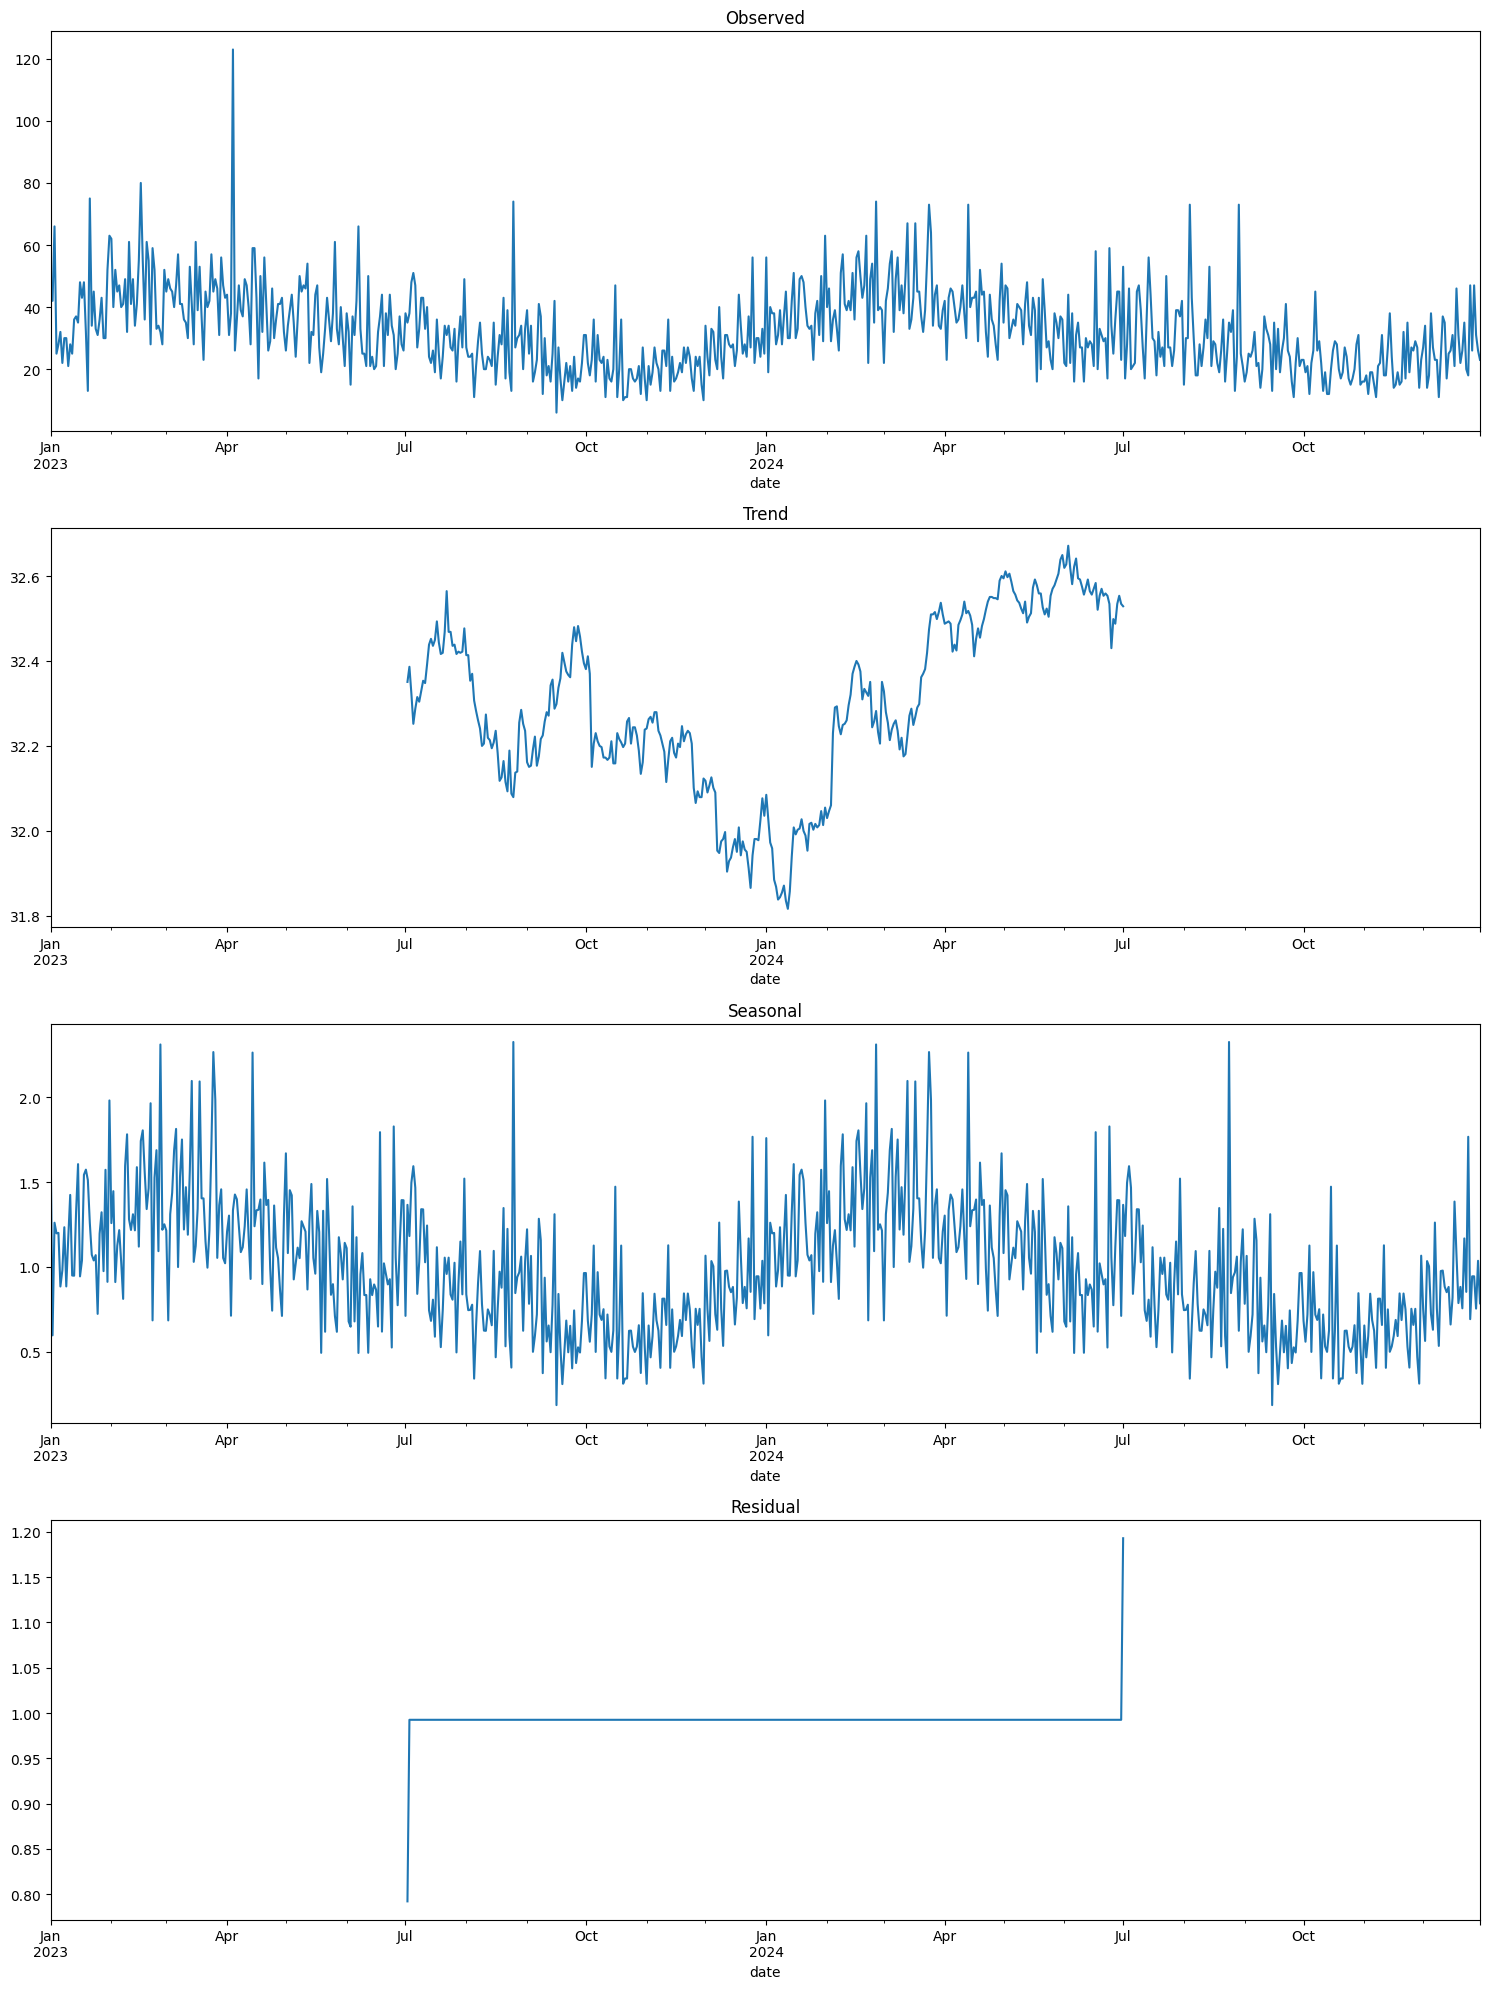

C:\Users\abhay\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\abhay\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\abhay\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


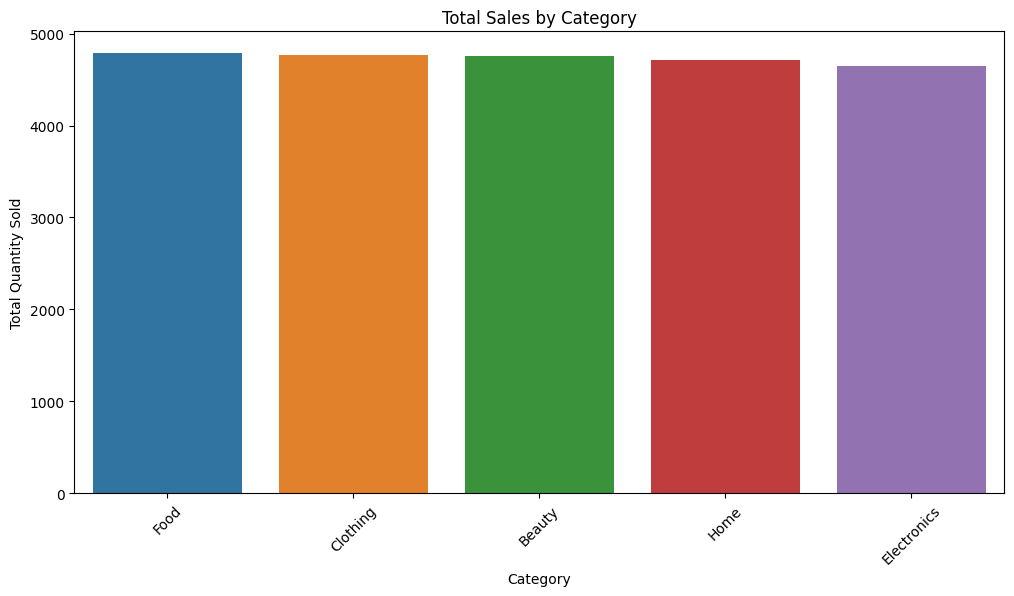

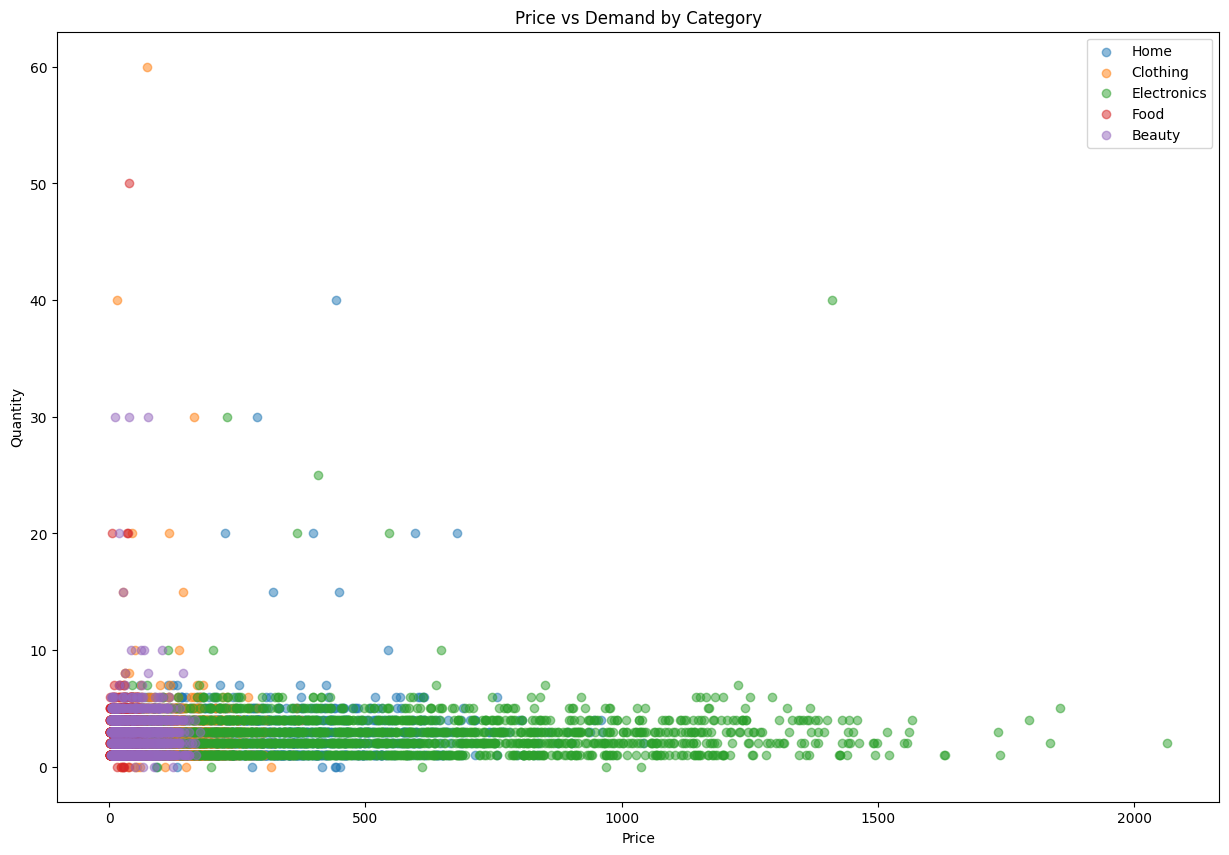

EDA complete.
Calculating price elasticities...
Building product network...
Network built with 100 nodes and 1024 edges at threshold 0.5
Analyzing product network...
Visualizing product network...


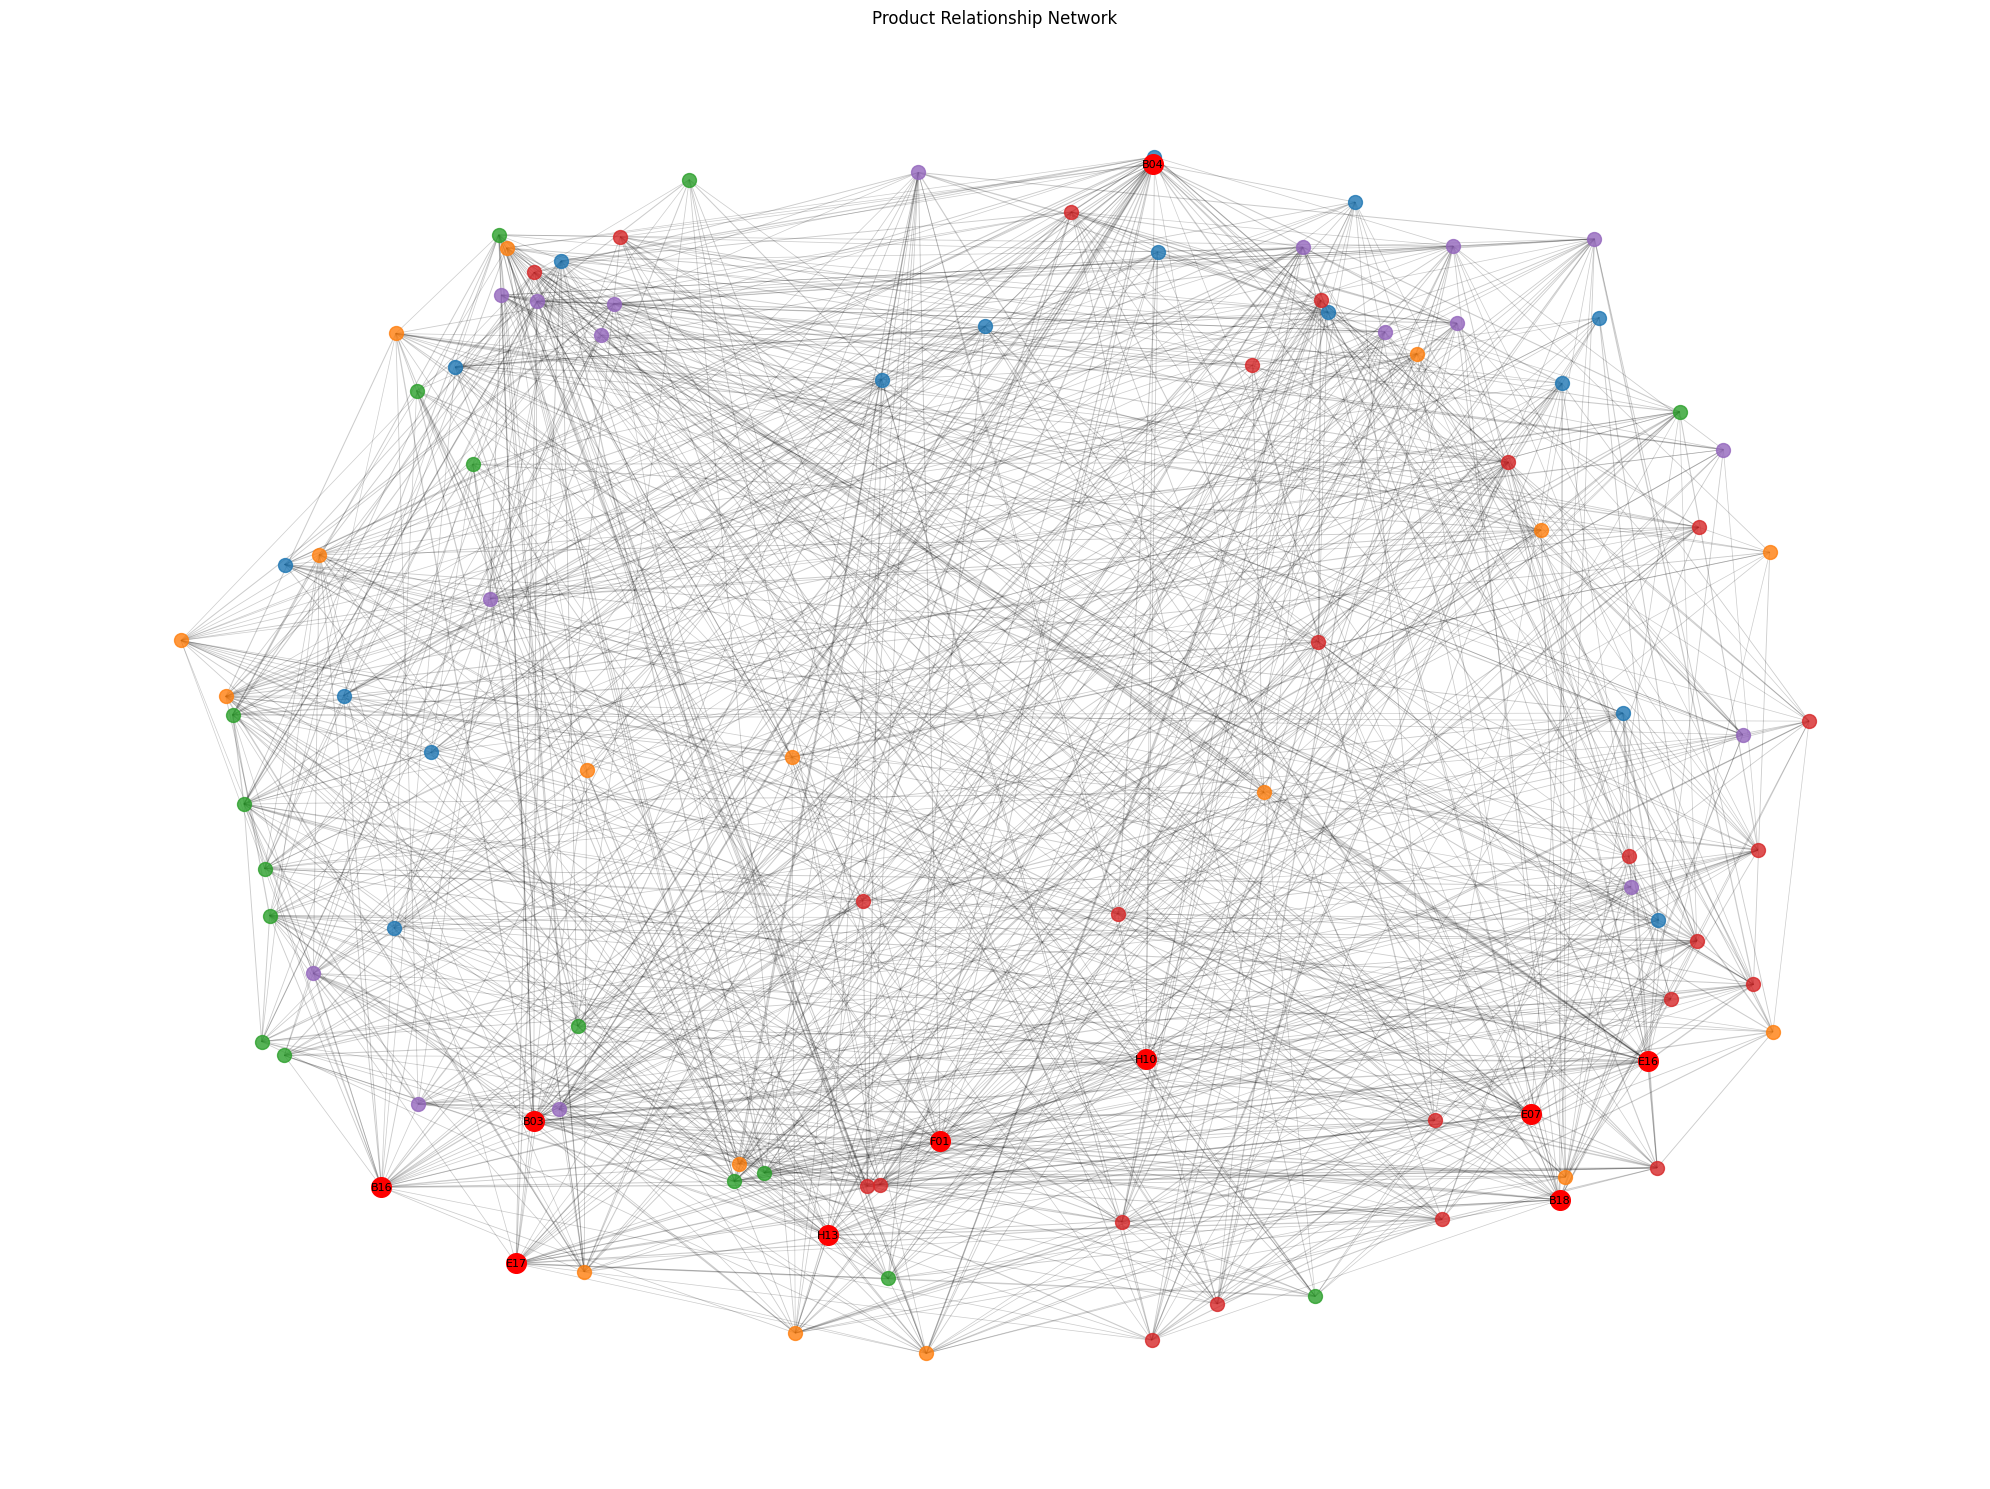

Performing Customer Segmentation...


C:\Users\abhay\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


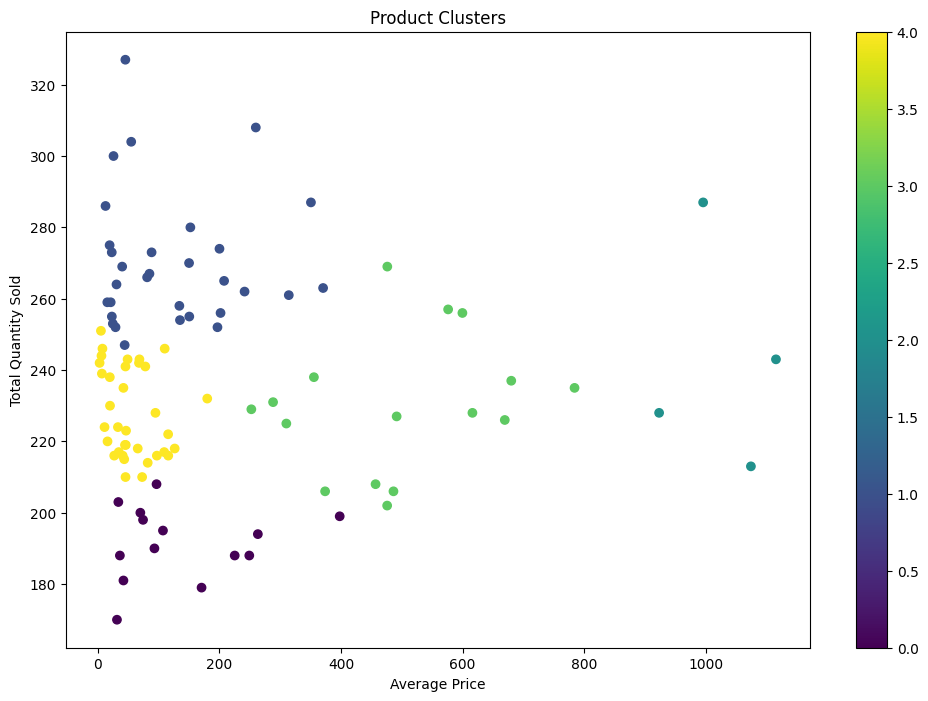


Product Clusters:
         product_id    quantity        price
cluster                                     
0                14  191.500000   134.916221
1                31  270.129032   120.142732
2                 4  242.750000  1027.464110
3                16  230.000000   493.324216
4                35  227.857143    56.305532
Forecasting Sales...


C:\Users\abhay\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\abhay\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


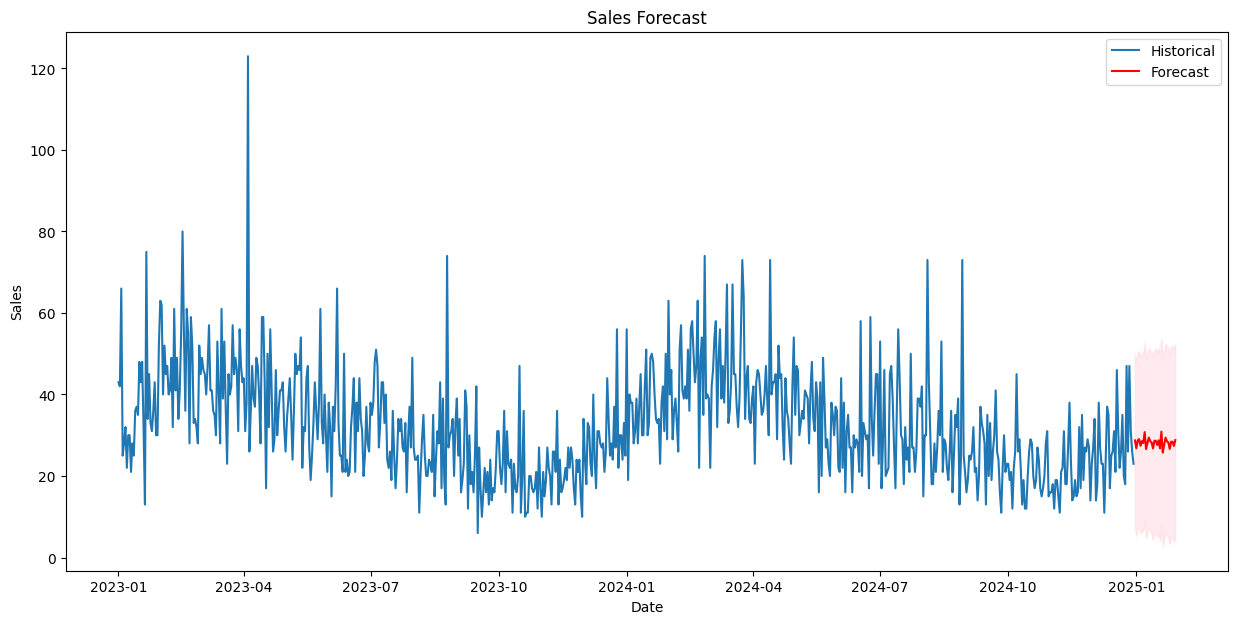

Forecasting complete.


In [2]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.linear_model import LinearRegression
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX

np.random.seed(42)  # Set the random seed for reproducibility

def generate_data(n_products=100, n_days=730, n_transactions=5000):
    print("Generating synthetic data...")
    
    categories = ['Electronics', 'Clothing', 'Home', 'Beauty', 'Food']
    base_prices = {
        'Electronics': np.random.uniform(50, 1000, size=20),
        'Clothing': np.random.uniform(10, 200, size=20),
        'Home': np.random.uniform(20, 500, size=20),
        'Beauty': np.random.uniform(5, 100, size=20),
        'Food': np.random.uniform(1, 50, size=20)
    }
    
    products = []
    for category in categories:
        for i in range(20):
            products.append({
                'id': f"{category[0]}{i+1:02d}",
                'category': category,
                'base_price': base_prices[category][i],
                'trend': np.random.uniform(-0.0005, 0.0005)
            })
    
    holidays = pd.to_datetime(['2023-01-01', '2023-07-04', '2023-11-24', '2023-12-25',
                               '2024-01-01', '2024-07-04', '2024-11-24', '2024-12-25'])
    promo_events = pd.date_range(start='2023-01-01', end='2024-12-31', freq='2W-MON')
    
    data = []
    for day in range(n_days):
        date = pd.Timestamp('2023-01-01') + pd.Timedelta(days=day)
        seasonal_factor = 1 + 0.3 * np.sin(2 * np.pi * day / 365) + 0.1 * np.sin(4 * np.pi * day / 365)
        seasonal_factor *= np.random.uniform(0.9, 1.1)  # Add up to 10% random variation
        holiday_factor = 1.5 if date in holidays else 1
        promo_factor = 1.2 if date in promo_events else 1
        daily_factor = seasonal_factor * holiday_factor * promo_factor
        
        for _ in range(int(n_transactions / n_days * daily_factor)):
            n_items = np.random.choice([1, 2, 3, 4, 5], p=[0.5, 0.25, 0.15, 0.07, 0.03])
            chosen_products = np.random.choice(products, n_items, replace=False)
            
            for product in chosen_products:
                trend_factor = 1 + product['trend'] * day
                price_factor = np.random.normal(1, 0.1) * trend_factor
                price = product['base_price'] * price_factor * daily_factor * np.random.uniform(0.9, 1.1)
                quantity = max(1, int(np.random.normal(3, 1.5)))
                
                if np.random.random() < 0.01:  # 1% chance of an outlier
                    quantity *= np.random.choice([0, 5, 10])
                
                data.append({
                    'date': date,
                    'product_id': product['id'],
                    'category': product['category'],
                    'price': round(price, 2),
                    'quantity': quantity
                })
    
    df = pd.DataFrame(data)
    df = df.sample(frac=0.98)  # Randomly remove 2% of the data
    print("Data generation complete.")
    return df

def introduce_typos(df, error_rate=0.001):
    mask = np.random.random(len(df)) < error_rate
    df.loc[mask, 'price'] *= 10  # Occasional price 10 times higher due to misplaced decimal
    return df

def perform_eda(df):
    print("Performing Exploratory Data Analysis...")
    
    daily_sales = df.groupby('date')['quantity'].sum().reset_index()
    plt.figure(figsize=(15, 7))
    plt.plot(daily_sales['date'], daily_sales['quantity'])
    plt.title('Daily Total Sales')
    plt.xlabel('Date')
    plt.ylabel('Total Quantity Sold')
    plt.show()

    sales_ts = daily_sales.set_index('date')['quantity']
    decomposition = seasonal_decompose(sales_ts, model='multiplicative', period=365)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 20))
    decomposition.observed.plot(ax=ax1)
    ax1.set_title('Observed')
    decomposition.trend.plot(ax=ax2)
    ax2.set_title('Trend')
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonal')
    decomposition.resid.plot(ax=ax4)
    ax4.set_title('Residual')
    plt.tight_layout()
    plt.show()

    category_sales = df.groupby('category')['quantity'].sum().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=category_sales.index, y=category_sales.values)
    plt.title('Total Sales by Category')
    plt.xlabel('Category')
    plt.ylabel('Total Quantity Sold')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(15, 10))
    for category in df['category'].unique():
        category_data = df[df['category'] == category]
        plt.scatter(category_data['price'], category_data['quantity'], alpha=0.5, label=category)
    plt.title('Price vs Demand by Category')
    plt.xlabel('Price')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

    print("EDA complete.")

def calculate_price_elasticity(df):
    print("Calculating price elasticities...")
    
    elasticities = {}
    for product in df['product_id'].unique():
        product_data = df[df['product_id'] == product]
        
        # Filter out zero or negative prices and quantities
        valid_data = product_data[(product_data['price'] > 0) & (product_data['quantity'] > 0)]
        
        if len(valid_data) < 2:  # Need at least 2 points for regression
            elasticities[product] = np.nan
            continue
        
        X = np.log(valid_data['price'].values).reshape(-1, 1)
        y = np.log(valid_data['quantity'].values)
        
        try:
            model = LinearRegression().fit(X, y)
            elasticity = model.coef_[0]
            elasticity *= np.random.uniform(0.9, 1.1)  # Add up to 10% random variation
        except ValueError:
            elasticity = np.nan
        
        elasticities[product] = elasticity
    
    return elasticities

def build_product_network(df, elasticities, initial_threshold=0.5):
    print("Building product network...")
    
    pivot_table = df.pivot_table(values='quantity', index='date', columns='product_id', aggfunc='sum')
    correlation_matrix = pivot_table.corr()
    
    G = nx.Graph()
    threshold = initial_threshold
    
    while G.number_of_edges() == 0 and threshold > 0:
        G.clear()
        for product1 in correlation_matrix.columns:
            for product2 in correlation_matrix.columns:
                if product1 != product2:
                    correlation = correlation_matrix.loc[product1, product2]
                    correlation += np.random.normal(0, 0.05)  # Add some noise to correlations
                    if abs(correlation) > threshold:
                        G.add_edge(product1, product2, weight=correlation, color='blue')
        
        if G.number_of_edges() == 0:
            threshold -= 0.1
            print(f"No edges found. Lowering threshold to {threshold:.1f}")
    
    if G.number_of_edges() == 0:
        print("Unable to build network. No significant correlations found.")
    else:
        print(f"Network built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges at threshold {threshold:.1f}")
    
    for product, elasticity in elasticities.items():
        if product in G.nodes:
            G.nodes[product]['elasticity'] = elasticity
    
    return G

def analyze_network(G, elasticities):
    print("Analyzing product network...")
    
    if G.number_of_nodes() == 0:
        print("Network is empty. Skipping analysis.")
        return [], [], [], []
    
    communities = list(nx.community.louvain_communities(G))
    
    centrality = nx.eigenvector_centrality(G)
    central_products = sorted(centrality, key=centrality.get, reverse=True)[:10]
    
    complements = []
    substitutes = []
    for edge in G.edges(data=True):
        product1, product2, data = edge
        if data['weight'] > 0:
            if elasticities[product1] * elasticities[product2] < 0:
                complements.append((product1, product2, data['weight']))
        else:
            if elasticities[product1] * elasticities[product2] > 0:
                substitutes.append((product1, product2, data['weight']))
    
    complements = sorted(complements, key=lambda x: abs(x[2]), reverse=True)
    substitutes = sorted(substitutes, key=lambda x: abs(x[2]), reverse=True)
    
    return communities, central_products, complements, substitutes

def visualize_network(G, communities, central_products):
    print("Visualizing product network...")
    
    if G.number_of_nodes() == 0:
        print("Network is empty. Skipping visualization.")
        return
    
    pos = nx.spring_layout(G)
    plt.figure(figsize=(20, 15))
    
    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=list(community), node_color=f'C{i}', node_size=100, alpha=0.8)
    
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=edge_weights)
    
    nx.draw_networkx_nodes(G, pos, nodelist=central_products, node_color='red', node_size=200)
    
    labels = {product: product for product in central_products}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title("Product Relationship Network")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def perform_customer_segmentation(df):
    print("Performing Customer Segmentation...")
    
    product_data = df.groupby('product_id').agg({
        'quantity': 'sum',
        'price': 'mean'
    }).reset_index()
    
    features = product_data[['quantity', 'price']]
    normalized_features = (features - features.mean()) / features.std()
    normalized_features += np.random.normal(0, 0.1, normalized_features.shape)
    
    kmeans = KMeans(n_clusters=5, random_state=42)
    product_data['cluster'] = kmeans.fit_predict(normalized_features)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(product_data['price'], product_data['quantity'], c=product_data['cluster'], cmap='viridis')
    plt.xlabel('Average Price')
    plt.ylabel('Total Quantity Sold')
    plt.title('Product Clusters')
    plt.colorbar(scatter)
    plt.show()
    
    print("\nProduct Clusters:")
    print(product_data.groupby('cluster').agg({
        'product_id': 'count',
        'quantity': 'mean',
        'price': 'mean'
    }))
    
    return product_data

def forecast_sales(df):
    print("Forecasting Sales...")
    
    daily_sales = df.groupby('date')['quantity'].sum()
    
    model = SARIMAX(daily_sales, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)
    
    forecast = results.get_forecast(steps=30)
    forecast_index = pd.date_range(daily_sales.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
    forecast_values = forecast.predicted_mean
    forecast_values += np.random.normal(0, forecast_values.std() * 0.1, len(forecast_values))
    conf_int = forecast.conf_int()
    
    plt.figure(figsize=(15, 7))
    plt.plot(daily_sales.index, daily_sales, label='Historical')
    plt.plot(forecast_index, forecast_values, color='red', label='Forecast')
    plt.fill_between(forecast_index, 
                     conf_int.iloc[:, 0], 
                     conf_int.iloc[:, 1], 
                     color='pink', alpha=0.3)
    plt.title('Sales Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

    print("Forecasting complete.")

def main():
    df = generate_data()
    
    
    perform_eda(df)
    
    elasticities = calculate_price_elasticity(df)
    
    G = build_product_network(df, elasticities)
    communities, central_products, complements, substitutes = analyze_network(G, elasticities)
    
    visualize_network(G, communities, central_products)
    
    
    
    segmented_products = perform_customer_segmentation(df)
    
    forecast_sales(df)
    

if __name__ == "__main__":
    main()

Generating synthetic data...
Data generation complete.
Calculating price elasticities...


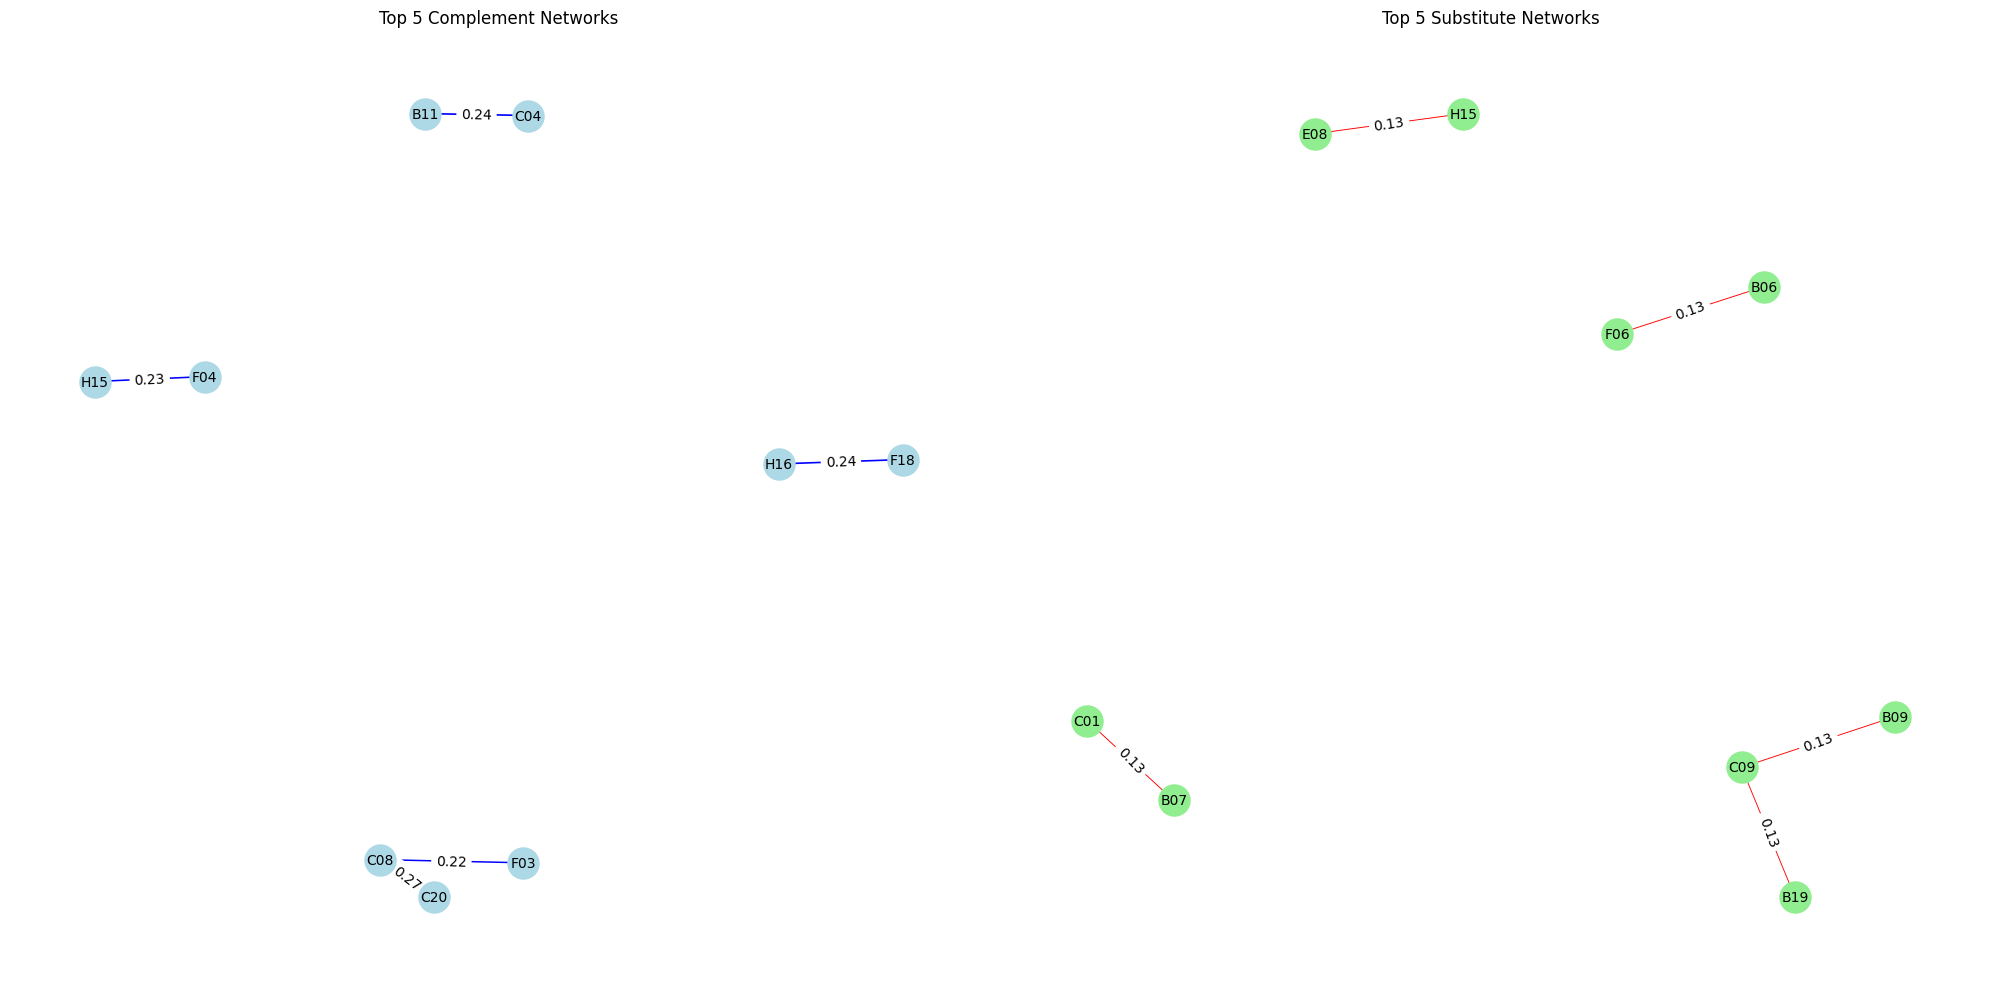

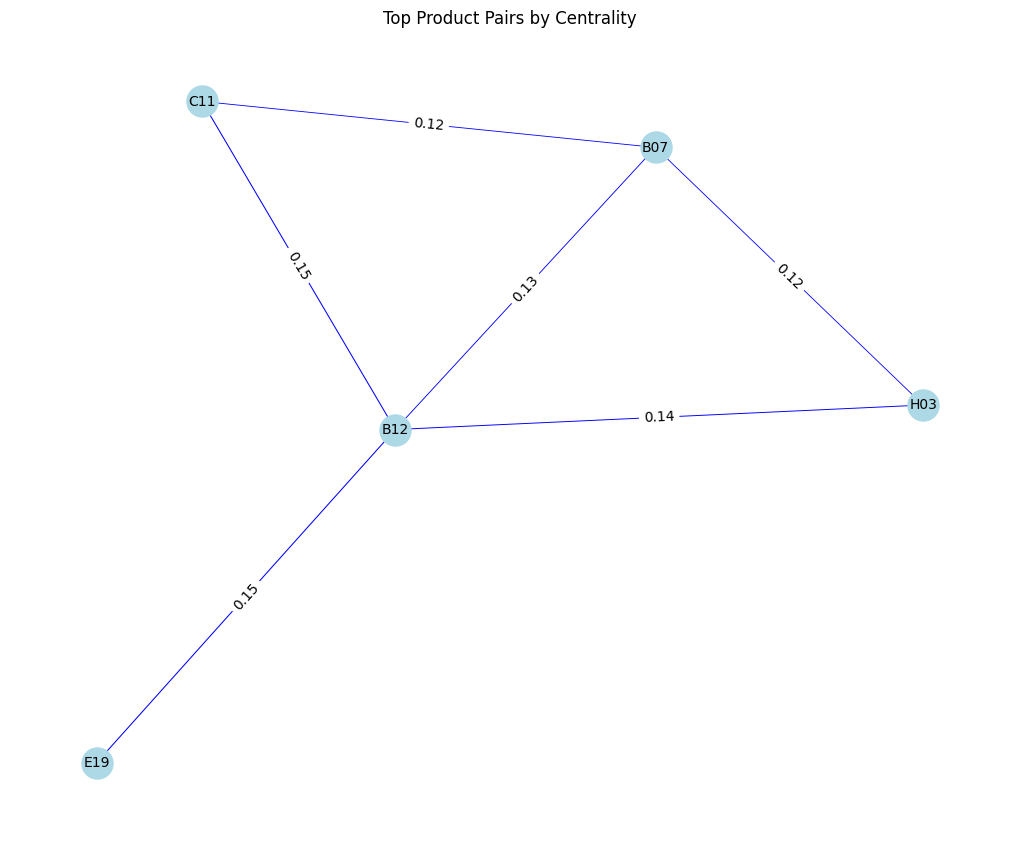


Top Product Pairs by Centrality:
  Pair: (B12, E19), Weight: 0.1497
  Pair: (B12, C11), Weight: 0.1494
  Pair: (B12, H03), Weight: 0.1363
  Pair: (B07, B12), Weight: 0.1284
  Pair: (B07, H03), Weight: 0.1213


C:\Users\abhay\AppData\Local\Programs\Python\Python311\Lib\site-packages\networkx\drawing\nx_pylab.py:304: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


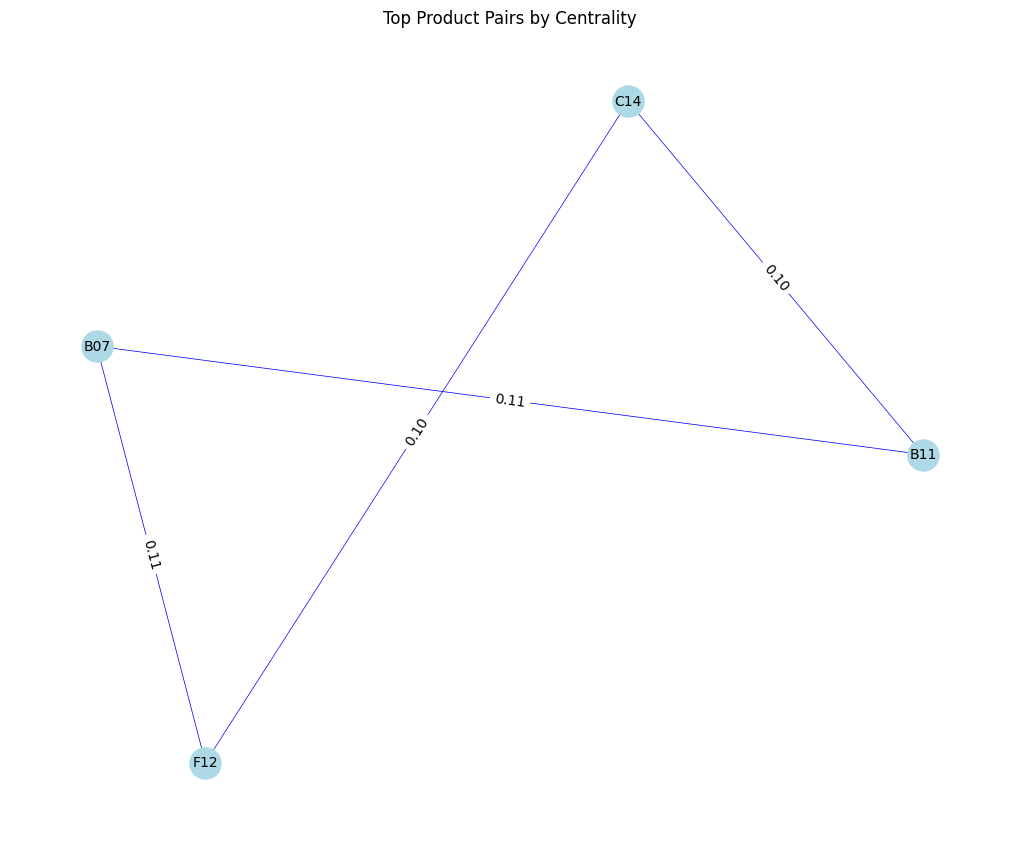


Top Product Pairs by Centrality:
  Pair: (F12, B07), Weight: 0.1070
  Pair: (B07, B11), Weight: 0.1060
  Pair: (C14, B11), Weight: 0.1031
  Pair: (F12, C14), Weight: 0.1016

Top Complement Products:
Product 1: C08, Product 2: C20, Weight (Complementarity): 0.27
Product 1: B11, Product 2: C04, Weight (Complementarity): 0.24
Product 1: F18, Product 2: H16, Weight (Complementarity): 0.24
Product 1: H15, Product 2: F04, Weight (Complementarity): 0.23
Product 1: F03, Product 2: C08, Weight (Complementarity): 0.22

Top Substitute Products:
Product 1: H15, Product 2: E08, Weight (Substitutability): 0.13
Product 1: B07, Product 2: C01, Weight (Substitutability): 0.13
Product 1: B06, Product 2: F06, Weight (Substitutability): 0.13
Product 1: C09, Product 2: B09, Weight (Substitutability): 0.13
Product 1: C09, Product 2: B19, Weight (Substitutability): 0.13


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.linear_model import LinearRegression
from scipy import stats
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import norm
from community import community_louvain
import random

# Set the seed for reproducibility
np.random.seed(42)
random.seed(42)

def generate_data(n_products=100, n_days=730, n_transactions=5000):
    print("Generating synthetic data...")
    
    categories = ['Electronics', 'Clothing', 'Home', 'Beauty', 'Food']
    base_prices = {
        'Electronics': np.random.uniform(50, 1000, size=20),
        'Clothing': np.random.uniform(10, 200, size=20),
        'Home': np.random.uniform(20, 500, size=20),
        'Beauty': np.random.uniform(5, 100, size=20),
        'Food': np.random.uniform(1, 50, size=20)
    }
    
    products = []
    for category in categories:
        for i in range(20):
            products.append({
                'id': f"{category[0]}{i+1:02d}",
                'category': category,
                'base_price': base_prices[category][i],
                'trend': np.random.uniform(-0.0005, 0.0005)
            })
    
    holidays = pd.to_datetime(['2023-01-01', '2023-07-04', '2023-11-24', '2023-12-25',
                               '2024-01-01', '2024-07-04', '2024-11-24', '2024-12-25'])
    promo_events = pd.date_range(start='2023-01-01', end='2024-12-31', freq='2W-MON')
    
    data = []
    for day in range(n_days):
        date = pd.Timestamp('2023-01-01') + pd.Timedelta(days=day)
        seasonal_factor = 1 + 0.3 * np.sin(2 * np.pi * day / 365) + 0.1 * np.sin(4 * np.pi * day / 365)
        seasonal_factor *= np.random.uniform(0.9, 1.1)
        holiday_factor = 1.5 if date in holidays else 1
        promo_factor = 1.2 if date in promo_events else 1
        daily_factor = seasonal_factor * holiday_factor * promo_factor
        
        for _ in range(int(n_transactions / n_days * daily_factor)):
            n_items = np.random.choice([1, 2, 3, 4, 5], p=[0.5, 0.25, 0.15, 0.07, 0.03])
            chosen_products = np.random.choice(products, n_items, replace=False)
            
            for product in chosen_products:
                trend_factor = 1 + product['trend'] * day
                price_factor = np.random.normal(1, 0.1) * trend_factor
                price = product['base_price'] * price_factor * daily_factor * np.random.uniform(0.9, 1.1)
                quantity = max(1, int(np.random.normal(3, 1.5)))
                
                if np.random.random() < 0.01:
                    quantity *= np.random.choice([0, 5, 10])
                
                data.append({
                    'date': date,
                    'product_id': product['id'],
                    'category': product['category'],
                    'price': round(price, 2),
                    'quantity': quantity
                })
    
    df = pd.DataFrame(data)
    df = df.sample(frac=0.98)
    print("Data generation complete.")
    return df

def introduce_typos(df, error_rate=0.001):
    mask = np.random.random(len(df)) < error_rate
    df.loc[mask, 'price'] *= 10
    return df

def calculate_price_elasticity(df):
    print("Calculating price elasticities...")
    
    elasticities = {}
    for product in df['product_id'].unique():
        product_data = df[df['product_id'] == product]
        
        valid_data = product_data[(product_data['price'] > 0) & (product_data['quantity'] > 0)]
        
        if len(valid_data) < 2:
            elasticities[product] = np.nan
            continue
        
        X = np.log(valid_data['price'].values).reshape(-1, 1)
        y = np.log(valid_data['quantity'].values)
        
        try:
            model = LinearRegression().fit(X, y)
            elasticity = model.coef_[0]
            elasticity *= np.random.uniform(0.9, 1.1)
        except ValueError:
            elasticity = np.nan
        
        elasticities[product] = elasticity
    
    return elasticities

def create_bipartite_network(transactions):
    B = nx.Graph()
    for i, transaction in enumerate(transactions):
        B.add_nodes_from([f't{i}'], bipartite=0)
        B.add_nodes_from(transaction, bipartite=1)
        B.add_edges_from([(f't{i}', product) for product in transaction])
    return B

def er_null_model(B, alpha_m, alpha_l):
    products = [n for n, d in B.nodes(data=True) if d['bipartite']==1]
    nt = len([n for n, d in B.nodes(data=True) if d['bipartite']==0])
    
    A_m = np.zeros((len(products), len(products)))
    A_l = np.zeros((len(products), len(products)))
    
    for i, prod1 in enumerate(products):
        for j, prod2 in enumerate(products):
            if i != j:
                pi = B.degree(prod1) / nt
                pj = B.degree(prod2) / nt
                mu = nt * pi * pj
                sigma = np.sqrt(nt * pi * pj * (1 - pi * pj))
                cn = len(list(nx.common_neighbors(B, prod1, prod2)))
                
                if cn > mu + norm.ppf(1-alpha_m) * sigma:
                    A_m[i,j] = 1
                if cn < mu:
                    A_l[i,j] = 1
    
    return A_m, A_l

def original_measure(B):
    products = [n for n, d in B.nodes(data=True) if d['bipartite'] == 1]
    transactions = [n for n, d in B.nodes(data=True) if d['bipartite'] == 0]
    
    sim = np.zeros((len(products), len(products)))
    
    for i, prod1 in enumerate(products):
        for j, prod2 in enumerate(products):
            numerator = sum([1/(B.degree(t)) for t in nx.common_neighbors(B, prod1, prod2)])
            denominator = np.sqrt(sum([1/(B.degree(t)) for t in B.neighbors(prod1)]) * sum([1/(B.degree(t)) for t in B.neighbors(prod2)]))
            if denominator != 0:
                sim[i,j] = numerator / denominator
    
    return sim

def calculate_substitutability_scores(B, A_l):
    products = [n for n, d in B.nodes(data=True) if d['bipartite'] == 1]
    transactions = [n for n, d in B.nodes(data=True) if d['bipartite'] == 0]
    
    W_s = np.zeros((len(products), len(products)))
    
    for i, prod1 in enumerate(products):
        for j, prod2 in enumerate(products):
            numerator = sum([1 / (B.degree(t)) for t in nx.common_neighbors(B, prod1, prod2)])
            denominator = np.sqrt(sum([1 / (B.degree(t)) for t in B.neighbors(prod1)]) * sum([1 / (B.degree(t)) for t in B.neighbors(prod2)]))
            if denominator != 0 and A_l[i, j] == 1:
                W_s[i, j] = numerator / denominator
    
    return W_s

def create_weighted_graph(W, products, threshold=0.1):
    G = nx.Graph()
    for i in range(len(products)):
        for j in range(i + 1, len(products)):
            if W[i, j] >= threshold:
                G.add_edge(products[i], products[j], weight=W[i, j])
    return G

def create_complement_substitute_networks(df):
    transactions = df.groupby('date')['product_id'].apply(list).tolist()
    
    B = create_bipartite_network(transactions)
    
    A_m, A_l = er_null_model(B, alpha_m=0.05, alpha_l=0.05)
    
    W_c = original_measure(B)
    W_s = calculate_substitutability_scores(B, A_l)
    
    products = [n for n, d in B.nodes(data=True) if d['bipartite'] == 1]
    
    G_c = create_weighted_graph(W_c, products, threshold=0.1)
    G_s = create_weighted_graph(W_s, products, threshold=0.1)
    
    return G_c, G_s

def calculate_centrality_measures(G):
    centrality = nx.degree_centrality(G)
    return centrality

def get_top_n_pairs(G, centrality, top_n=5):
    top_products = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_product_ids = {product for product, _ in top_products}
    
    top_pairs = [(u, v, d['weight']) for u, v, d in G.edges(data=True)
                 if u in top_product_ids and v in top_product_ids]
    
    top_pairs_sorted = sorted(top_pairs, key=lambda x: x[2], reverse=True)
    
    return top_pairs_sorted[:top_n]

def visualize_complement_substitute_networks(G_c, G_s, top_n=5):
    def get_top_networks(G, top_n=5):
        edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
        top_edges = edges[:top_n]
        
        subgraph = G.edge_subgraph([(u, v) for u, v, _ in top_edges]).copy()
        
        return subgraph
    
    top_complement_graph = get_top_networks(G_c, top_n)
    top_substitute_graph = get_top_networks(G_s, top_n)
    
    plt.figure(figsize=(20, 10))
    
    plt.subplot(121)
    pos = nx.spring_layout(top_complement_graph)
    nx.draw(top_complement_graph, pos, with_labels=True, node_color='lightblue', 
            node_size=500, font_size=10, edge_color='blue', width=[d['weight']*5 for _, _, d in top_complement_graph.edges(data=True)])
    nx.draw_networkx_edge_labels(top_complement_graph, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in top_complement_graph.edges(data=True)})
    plt.title('Top 5 Complement Networks')
    
    plt.subplot(122)
    pos = nx.spring_layout(top_substitute_graph)
    nx.draw(top_substitute_graph, pos, with_labels=True, node_color='lightgreen', 
            node_size=500, font_size=10, edge_color='red', width=[d['weight']*5 for _, _, d in top_substitute_graph.edges(data=True)])
    nx.draw_networkx_edge_labels(top_substitute_graph, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in top_substitute_graph.edges(data=True)})
    plt.title('Top 5 Substitute Networks')
    
    plt.tight_layout()
    plt.show()

def visualize_and_report_top_pairs(G, centrality, top_n=5):
    top_pairs = get_top_n_pairs(G, centrality, top_n)
    
    plt.figure(figsize=(10, 8))
    
    top_nodes = set()
    for u, v, _ in top_pairs:
        top_nodes.add(u)
        top_nodes.add(v)
    
    subgraph = G.subgraph(top_nodes).copy()
    for u, v, weight in top_pairs:
        if not subgraph.has_edge(u, v):
            subgraph.add_edge(u, v, weight=weight)
    
    pos = nx.spring_layout(subgraph, seed=42)
    nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', 
            node_size=500, font_size=10, edge_color='blue', width=[d['weight']*5 for _, _, d in subgraph.edges(data=True)])
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in subgraph.edges(data=True)})
    plt.title("Top Product Pairs by Centrality")
    plt.show()
    
    print("\nTop Product Pairs by Centrality:")
    for u, v, weight in top_pairs:
        print(f"  Pair: ({u}, {v}), Weight: {weight:.4f}")

def report_top_complement_substitute_products(G_c, G_s, top_n=5):
    def get_top_products(G, top_n=5):
        # Get edges sorted by weight in descending order
        edges = sorted(G.edges(data=True), key=lambda x: x[2].get('weight', 0), reverse=True)
        top_edges = edges[:top_n]
        return top_edges
    
    top_complement_products = get_top_products(G_c, top_n)
    top_substitute_products = get_top_products(G_s, top_n)
    
    print("\nTop Complement Products:")
    for u, v, data in top_complement_products:
        weight = data.get('weight', 0)
        print(f"Product 1: {u}, Product 2: {v}, Weight (Complementarity): {weight:.2f}")
    
    print("\nTop Substitute Products:")
    
    for u, v, data in top_substitute_products:
        weight = data.get('weight', 0)
        print(f"Product 1: {u}, Product 2: {v}, Weight (Substitutability): {weight:.2f}")


def main():
    df = generate_data()
    df = introduce_typos(df)
    
    elasticities = calculate_price_elasticity(df)
    
    G_c, G_s = create_complement_substitute_networks(df)
    
    visualize_complement_substitute_networks(G_c, G_s, top_n=5)
    
    centrality_c = calculate_centrality_measures(G_c)
    centrality_s = calculate_centrality_measures(G_s)
    
    visualize_and_report_top_pairs(G_c, centrality_c, top_n=5)
    visualize_and_report_top_pairs(G_s, centrality_s, top_n=5)
    
    report_top_complement_substitute_products(G_c, G_s, top_n=5)

if __name__ == "__main__":
    main()


In [4]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

np.random.seed(42)
random.seed(42)  # Set the random seed for reproducibility

def main():
    # Generate synthetic data
    df = generate_data()

    # Introduce typos to the data
    df = introduce_typos(df)
    
    # Extract transactions as a list of product IDs per day
    transactions = df.groupby('date')['product_id'].apply(list).tolist()

    # Create a DataFrame with all unique products as columns
    all_products = sorted(set(df['product_id']))
    transaction_encoded = pd.DataFrame(
        [[product in transaction for product in all_products] for transaction in transactions],
        columns=all_products
    )
    
    # Apply the Apriori algorithm
    itemsets = apriori(transaction_encoded, min_support=0.01, use_colnames=True)
    rules = association_rules(itemsets, metric="lift", min_threshold=1.0)
    
    # Sort rules by the chosen metric (e.g., 'lift') and get top 5
    top_5_rules = rules.nlargest(5, 'lift')
    
    # Output the top 5 rules with detailed formatting
    print("\nTop 5 Product Pair Recommendations:")
    for index, rule in top_5_rules.iterrows():
        antecedents = ', '.join(rule['antecedents'])
        consequents = ', '.join(rule['consequents'])
        print(f"\nRecommendation {index + 1}:")
        print(f"  If a customer buys: {antecedents}")
        print(f"  Then recommend: {consequents}")
        print(f"  Why? These products are often bought together.")
        print(f"  - Strength of relationship (Lift): {rule['lift']:.2f}")
        print(f"  - Confidence in this recommendation: {rule['confidence']:.2f}")
        print(f"  - Frequency in transactions (Support): {rule['support']:.2f}")

if __name__ == "__main__":
    main()


Generating synthetic data...
Data generation complete.

Top 5 Product Pair Recommendations:

Recommendation 5299:
  If a customer buys: B18, B11
  Then recommend: C04
  Why? These products are often bought together.
  - Strength of relationship (Lift): 5.41
  - Confidence in this recommendation: 0.62
  - Frequency in transactions (Support): 0.01

Recommendation 5304:
  If a customer buys: C04
  Then recommend: B18, B11
  Why? These products are often bought together.
  - Strength of relationship (Lift): 5.41
  - Confidence in this recommendation: 0.10
  - Frequency in transactions (Support): 0.01

Recommendation 5324:
  If a customer buys: F10, F15
  Then recommend: H06
  Why? These products are often bought together.
  - Strength of relationship (Lift): 4.97
  - Confidence in this recommendation: 0.57
  - Frequency in transactions (Support): 0.01

Recommendation 5327:
  If a customer buys: H06
  Then recommend: F10, F15
  Why? These products are often bought together.
  - Strength of 

In [5]:

import numpy as np
import pandas as pd
# Set the seed for reproducibility
np.random.seed(42)
random.seed(42)
def rule_based_decision(df):
    print("Generating Rule-Based Observations...")
    
    # Calculate percentage changes
    df['price_change'] = df.groupby('product_id')['price'].pct_change().fillna(0) * 100
    df['demand_change'] = df.groupby('product_id')['quantity'].pct_change().fillna(0) * 100
    
    # Clip price changes to a maximum of ±30%
    def clip_changes(x, max_change=30):
        return np.clip(x, -max_change, max_change)
    
    df['price_change'] = df['price_change'].apply(lambda x: clip_changes(x))
    
    # Replace infinite values in demand_change with NaN
    df['demand_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Apply rules and filter data
    increase_and_increase = df[(df['price_change'] > 10) & (df['demand_change'] > 0)]
    increase_and_decrease = df[(df['price_change'] > 10) & (df['demand_change'] < 0)]
    decrease_and_increase = df[(df['price_change'] < -10) & (df['demand_change'] > 0)]
    decrease_and_decrease = df[(df['price_change'] < -10) & (df['demand_change'] < 0)]
    
    # Summarize the observations for each case
    increase_and_increase_summary = increase_and_increase.groupby('product_id').agg({
        'price_change': 'mean',
        'demand_change': 'mean',
        'quantity': 'sum'
    }).reset_index()
    
    increase_and_decrease_summary = increase_and_decrease.groupby('product_id').agg({
        'price_change': 'mean',
        'demand_change': 'mean',
        'quantity': 'sum'
    }).reset_index()
    
    decrease_and_increase_summary = decrease_and_increase.groupby('product_id').agg({
        'price_change': 'mean',
        'demand_change': 'mean',
        'quantity': 'sum'
    }).reset_index()
    
    decrease_and_decrease_summary = decrease_and_decrease.groupby('product_id').agg({
        'price_change': 'mean',
        'demand_change': 'mean',
        'quantity': 'sum'
    }).reset_index()
    
    # Sort summaries by price_change to find the most significant rules
    increase_and_increase_summary = increase_and_increase_summary.sort_values(by='price_change', ascending=False)
    increase_and_decrease_summary = increase_and_decrease_summary.sort_values(by='price_change', ascending=False)
    decrease_and_increase_summary = decrease_and_increase_summary.sort_values(by='price_change', ascending=True)
    decrease_and_decrease_summary = decrease_and_decrease_summary.sort_values(by='price_change', ascending=True)
    
    # Select the top 5 most significant rules for each scenario
    top_increase_and_increase = increase_and_increase_summary.head(5)
    top_increase_and_decrease = increase_and_decrease_summary.head(5)
    top_decrease_and_increase = decrease_and_increase_summary.head(5)
    top_decrease_and_decrease = decrease_and_decrease_summary.head(5)
    
    print("\nTop 5 Rules for Price Increase and Demand Increase:")
    for index, row in top_increase_and_increase.iterrows():
        print(f"\nProduct ID: {row['product_id']}")
        print(f"  Average Price Change: {row['price_change']:.2f}%")
        print(f"  Average Demand Change: {row['demand_change']:.2f}%")
        print(f"  Total Quantity Sold During Price Increase: {row['quantity']}")
        print(f"  Observations: This product experienced an average price increase of {row['price_change']:.2f}%,")
        print(f"  which is associated with a {row['demand_change']:.2f}% increase in demand. The total quantity sold")
        print(f"  during these price increases was {row['quantity']} units.")
    
    print("\nTop 5 Rules for Price Increase and Demand Decrease:")
    for index, row in top_increase_and_decrease.iterrows():
        print(f"\nProduct ID: {row['product_id']}")
        print(f"  Average Price Change: {row['price_change']:.2f}%")
        print(f"  Average Demand Change: {row['demand_change']:.2f}%")
        print(f"  Total Quantity Sold During Price Increase: {row['quantity']}")
        print(f"  Observations: This product experienced an average price increase of {row['price_change']:.2f}%,")
        print(f"  which is associated with a {row['demand_change']:.2f}% decrease in demand. The total quantity sold")
        print(f"  during these price increases was {row['quantity']} units.")
    
    print("\nTop 5 Rules for Price Decrease and Demand Increase:")
    for index, row in top_decrease_and_increase.iterrows():
        print(f"\nProduct ID: {row['product_id']}")
        print(f"  Average Price Change: {row['price_change']:.2f}%")
        print(f"  Average Demand Change: {row['demand_change']:.2f}%")
        print(f"  Total Quantity Sold During Price Decrease: {row['quantity']}")
        print(f"  Observations: This product experienced an average price decrease of {row['price_change']:.2f}%,")
        print(f"  which is associated with a {row['demand_change']:.2f}% increase in demand. The total quantity sold")
        print(f"  during these price decreases was {row['quantity']} units.")
    
    print("\nTop 5 Rules for Price Decrease and Demand Decrease:")
    for index, row in top_decrease_and_decrease.iterrows():
        print(f"\nProduct ID: {row['product_id']}")
        print(f"  Average Price Change: {row['price_change']:.2f}%")
        print(f"  Average Demand Change: {row['demand_change']:.2f}%")
        print(f"  Total Quantity Sold During Price Decrease: {row['quantity']}")
        print(f"  Observations: This product experienced an average price decrease of {row['price_change']:.2f}%,")
        print(f"  which is associated with a {row['demand_change']:.2f}% decrease in demand. The total quantity sold")
        print(f"  during these price decreases was {row['quantity']} units.")
    
    return (top_increase_and_increase, top_increase_and_decrease,
            top_decrease_and_increase, top_decrease_and_decrease)

# Main pipeline
if __name__ == "__main__":
    df = generate_data()  # Generate or load your data
    
    # Ensure 'main()' or other functions are defined if needed
    top_increase_and_increase, top_increase_and_decrease, top_decrease_and_increase, top_decrease_and_decrease = rule_based_decision(df)


Generating synthetic data...
Data generation complete.
Generating Rule-Based Observations...

Top 5 Rules for Price Increase and Demand Increase:

Product ID: F02
  Average Price Change: 30.00%
  Average Demand Change: 114.81%
  Total Quantity Sold During Price Increase: 33
  Observations: This product experienced an average price increase of 30.00%,
  which is associated with a 114.81% increase in demand. The total quantity sold
  during these price increases was 33 units.

Product ID: E05
  Average Price Change: 30.00%
  Average Demand Change: 164.29%
  Total Quantity Sold During Price Increase: 23
  Observations: This product experienced an average price increase of 30.00%,
  which is associated with a 164.29% increase in demand. The total quantity sold
  during these price increases was 23 units.

Product ID: B07
  Average Price Change: 29.49%
  Average Demand Change: 112.22%
  Total Quantity Sold During Price Increase: 43
  Observations: This product experienced an average price i

Generating synthetic data...
Data generation complete.
Top 5 changes in complement relationships:
H19 - F08: Removed (weight: 1.00)
E18 - F17: Added (weight: 1.00)
F08 - H19: Removed (weight: 1.00)
C18 - H11: Removed (weight: 1.00)
E06 - C06: Added (weight: 1.00)

Top 5 changes in substitute relationships:
E18 - F17: Removed (weight: 1.00)
C18 - H11: Added (weight: 1.00)
F06 - H11: Added (weight: 1.00)
C06 - E06: Removed (weight: 1.00)
B01 - H04: Removed (weight: 1.00)
Nodes before: {'H13', 'E12', 'F03', 'C01', 'F11', 'H11', 'C09', 'H19', 'E06', 'C18'}
Nodes after: {'H13', 'E12', 'F03', 'C01', 'F11', 'H11', 'C09', 'H19', 'E06', 'C18'}
Top products: ['C18', 'C01', 'F03', 'H11', 'H19', 'F11', 'H13', 'C09', 'E06', 'E12']
Positions keys: dict_keys(['H13', 'E12', 'F03', 'C01', 'F11', 'H11', 'C09', 'H19', 'E06', 'C18'])


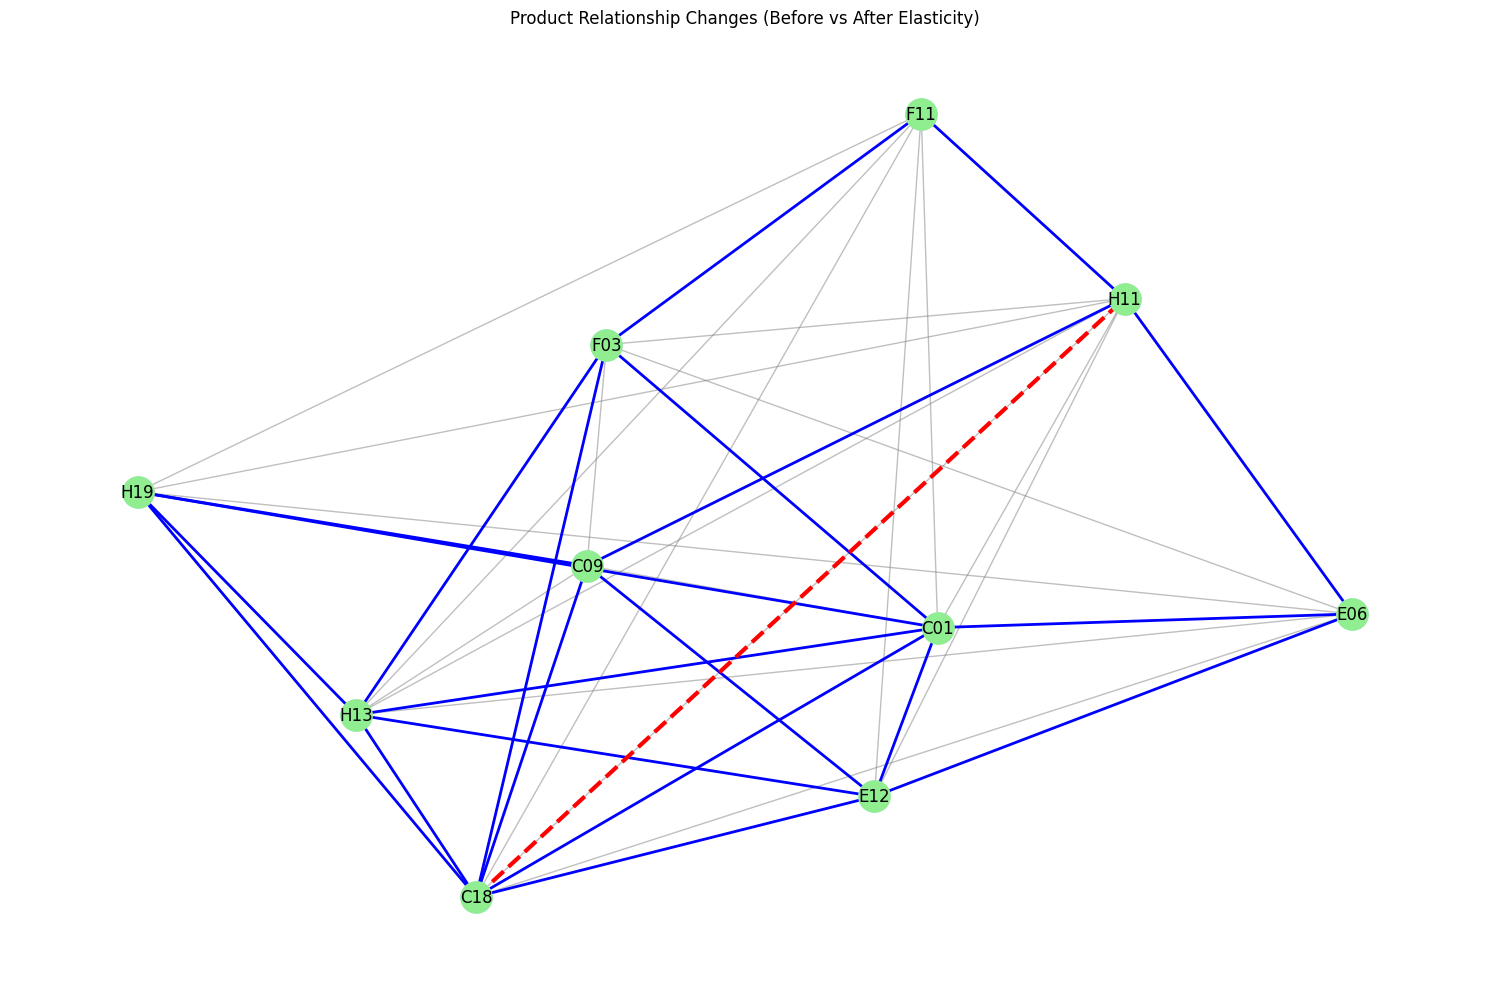

Nodes before: {'E15', 'E17', 'E10', 'E04', 'H07', 'F10', 'C03', 'H02', 'E08', 'H14'}
Nodes after: {'E15', 'E17', 'E10', 'E04', 'H07', 'F10', 'C03', 'H02', 'E08', 'H14'}
Top products: ['F10', 'E17', 'E04', 'C03', 'H02', 'E10', 'E08', 'H14', 'E15', 'H07']
Positions keys: dict_keys(['E15', 'E17', 'E04', 'E10', 'H07', 'F10', 'C03', 'H02', 'E08', 'H14'])


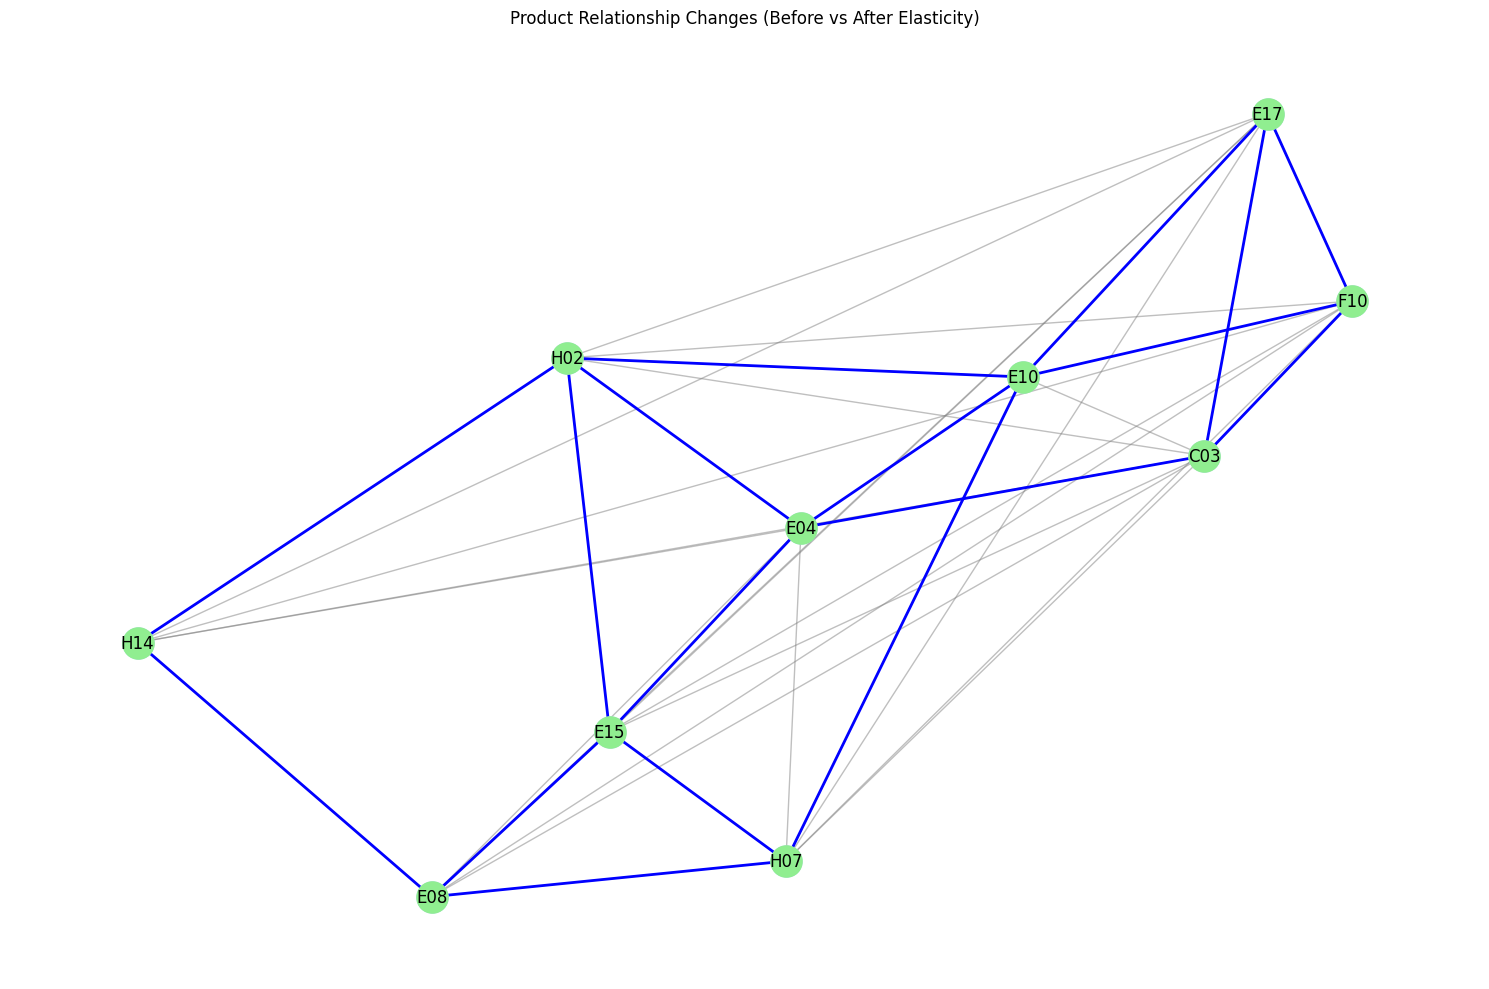

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.linear_model import LinearRegression
np.random.seed(42)
def calculate_price_elasticity(df):
    elasticities = {}
    for product in df['product_id'].unique():
        product_data = df[df['product_id'] == product]
        valid_data = product_data[(product_data['price'] > 0) & (product_data['quantity'] > 0)]
        if len(valid_data) < 2:
            elasticities[product] = np.nan
            continue
        X = np.log(valid_data['price'].values).reshape(-1, 1)
        y = np.log(valid_data['quantity'].values)
        try:
            model = LinearRegression().fit(X, y)
            elasticity = model.coef_[0]
        except ValueError:
            elasticity = np.nan
        elasticities[product] = elasticity
    return elasticities

def create_product_networks(df, elasticities=None):
    pivot_table = df.pivot_table(values='quantity', index='date', columns='product_id', aggfunc='sum')
    correlation_matrix = pivot_table.corr()
    
    G_c = nx.Graph()
    G_s = nx.Graph()
    
    for product1 in correlation_matrix.columns:
        for product2 in correlation_matrix.columns:
            if product1 != product2:
                corr = correlation_matrix.loc[product1, product2]
                if elasticities:
                    e1, e2 = elasticities.get(product1, 0), elasticities.get(product2, 0)
                    if e1 * e2 > 0:  # Same sign elasticities
                        if corr > 0:
                            G_c.add_edge(product1, product2, weight=corr)
                        elif corr < 0:
                            G_s.add_edge(product1, product2, weight=-corr)
                    else:  # Different sign elasticities
                        if corr > 0:
                            G_s.add_edge(product1, product2, weight=corr)
                        elif corr < 0:
                            G_c.add_edge(product1, product2, weight=-corr)
                else:
                    if corr > 0:
                        G_c.add_edge(product1, product2, weight=corr)
                    elif corr < 0:
                        G_s.add_edge(product1, product2, weight=-corr)
    
    return G_c, G_s

def compare_networks(G1, G2):
    changes = []
    for edge in set(G1.edges()) ^ set(G2.edges()):
        if edge in G1.edges():
            changes.append((edge[0], edge[1], 'Removed', G1.edges[edge]['weight']))
        else:
            changes.append((edge[0], edge[1], 'Added', G2.edges[edge]['weight']))
    return sorted(changes, key=lambda x: abs(x[3]), reverse=True)[:5]

def visualize_network_changes(G_before, G_after, changes, top_products):
    # Filter graphs to include only top products
    subgraph_before = G_before.subgraph(top_products).copy()
    subgraph_after = G_after.subgraph(top_products).copy()

    # Compute layout for both subgraphs
    pos_before = nx.spring_layout(subgraph_before)
    pos_after = nx.spring_layout(subgraph_after)

    # Create combined positions to ensure all nodes are included
    pos = {**pos_before, **pos_after}

    # Debugging: Check node consistency
    nodes_before = set(subgraph_before.nodes())
    nodes_after = set(subgraph_after.nodes())
    print(f"Nodes before: {nodes_before}")
    print(f"Nodes after: {nodes_after}")
    print(f"Top products: {top_products}")
    print(f"Positions keys: {pos.keys()}")

    # Ensure all changes involve nodes in the subgraph
    valid_changes = [change for change in changes if change[0] in pos and change[1] in pos]
    
    plt.figure(figsize=(15, 10))

    # Draw the nodes and edges
    nx.draw_networkx_nodes(subgraph_before, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_edges(subgraph_before, pos, edge_color='gray', width=1, alpha=0.5)
    
    nx.draw_networkx_nodes(subgraph_after, pos, node_color='lightgreen', node_size=500)
    nx.draw_networkx_edges(subgraph_after, pos, edge_color='blue', width=2)
    
    for change in valid_changes:
        if change[2] == 'Added':
            nx.draw_networkx_edges(subgraph_after, pos, edgelist=[(change[0], change[1])], edge_color='green', width=3)
        else:
            nx.draw_networkx_edges(subgraph_before, pos, edgelist=[(change[0], change[1])], edge_color='red', width=3, style='dashed')
    
    nx.draw_networkx_labels(nx.compose(subgraph_before, subgraph_after), pos)
    
    plt.title("Product Relationship Changes (Before vs After Elasticity)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def main():
    df = generate_data()  # Assume this function exists and generates your dataset
    
    # Create networks before considering elasticity
    G_c_before, G_s_before = create_product_networks(df)
    
    # Calculate price elasticity
    elasticities = calculate_price_elasticity(df)
    
    # Create networks after considering elasticity
    G_c_after, G_s_after = create_product_networks(df, elasticities)
    
    # Compare networks and get top 5 changes
    complement_changes = compare_networks(G_c_before, G_c_after)
    substitute_changes = compare_networks(G_s_before, G_s_after)
    
    print("Top 5 changes in complement relationships:")
    for change in complement_changes:
        print(f"{change[0]} - {change[1]}: {change[2]} (weight: {change[3]:.2f})")
    
    print("\nTop 5 changes in substitute relationships:")
    for change in substitute_changes:
        print(f"{change[0]} - {change[1]}: {change[2]} (weight: {change[3]:.2f})")
    
    # Filter top products (for example, top 10 products by centrality)
    centrality_before = nx.degree_centrality(G_c_before)
    top_products_c = sorted(centrality_before, key=centrality_before.get, reverse=True)[:10]
    
    centrality_before_s = nx.degree_centrality(G_s_before)
    top_products_s = sorted(centrality_before_s, key=centrality_before_s.get, reverse=True)[:10]
    
    # Visualize changes for complement and substitute relationships
    visualize_network_changes(G_c_before, G_c_after, complement_changes, top_products_c)
    visualize_network_changes(G_s_before, G_s_after, substitute_changes, top_products_s)

if __name__ == "__main__":
    main()


In [8]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
np.random.seed(42) 
def main():
    # Generate synthetic data
    df = generate_data()

    
    # Define price bins
    price_bins = [0, 10, 20, 50, 100, 200, 500, 1000]
    labels = [f"${int(price_bins[i])}-${int(price_bins[i+1])}" for i in range(len(price_bins)-1)]
    
    # Add price bins to the data
    df['price_range'] = pd.cut(df['price'], bins=price_bins, labels=labels, include_lowest=True)
    
    # Combine product ID and price range
    df['product_price'] = df['product_id'] + "_" + df['price_range'].astype(str)
    
    # Extract transactions as a list of product-price combinations per day
    transactions = df.groupby('date')['product_price'].apply(list).tolist()

    # Create a DataFrame with all unique product-price combinations as columns
    all_products_prices = sorted(set(df['product_price']))
    transaction_encoded = pd.DataFrame(
        [[product in transaction for product in all_products_prices] for transaction in transactions],
        columns=all_products_prices
    )
    
    # Apply the Apriori algorithm
    itemsets = apriori(transaction_encoded, min_support=0.01, use_colnames=True)
    rules = association_rules(itemsets, metric="lift", min_threshold=1.0)
    
    # Sort rules by the chosen metric (e.g., 'lift') and get top 5
    top_5_rules = rules.nlargest(5, 'lift')
    
    # Output the top 5 rules with detailed formatting
    print("\nTop 5 Product Pair Recommendations (Considering Price Ranges):")
    for index, rule in top_5_rules.iterrows():
        antecedents = ', '.join(list(rule['antecedents']))
        consequents = ', '.join(list(rule['consequents']))
        print(f"\nRecommendation {index + 1}:")
        print(f"  If a customer buys: {antecedents}")
        print(f"  Then recommend: {consequents}")
        print(f"  Why? These products in the specified price ranges are often bought together.")
        print(f"  - Strength of relationship (Lift): {rule['lift']:.2f}")
        print(f"  - Confidence in this recommendation: {rule['confidence']:.2f}")
        print(f"  - Frequency in transactions (Support): {rule['support']:.2f}")

if __name__ == "__main__":
    main()


Generating synthetic data...
Data generation complete.

Top 5 Product Pair Recommendations (Considering Price Ranges):

Recommendation 707:
  If a customer buys: C06_$200-$500
  Then recommend: B17_$100-$200
  Why? These products in the specified price ranges are often bought together.
  - Strength of relationship (Lift): 6.08
  - Confidence in this recommendation: 0.33
  - Frequency in transactions (Support): 0.01

Recommendation 708:
  If a customer buys: B17_$100-$200
  Then recommend: C06_$200-$500
  Why? These products in the specified price ranges are often bought together.
  - Strength of relationship (Lift): 6.08
  - Confidence in this recommendation: 0.20
  - Frequency in transactions (Support): 0.01

Recommendation 351:
  If a customer buys: C16_$200-$500
  Then recommend: B10_$100-$200
  Why? These products in the specified price ranges are often bought together.
  - Strength of relationship (Lift): 5.69
  - Confidence in this recommendation: 0.42
  - Frequency in transactio